In [ ]:
!pip install rouge_score -qU
!pip install sentencepiece -qU
!pip install rouge_score googletrans -qU
!pip install rouge-score bert-score -qU
!pip install transformers -qU
!python -m spacy download ru_core_news_md -qU

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 827.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.7 MB/s eta 0:00:00
2023-12-23 07:57:40.916056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN 

In [ ]:
!python -m spacy download ru_core_news_md -qU

2023-12-23 08:05:28.522829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 08:05:28.522877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 08:05:28.527541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 08:05:28.552815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 08:05:32.450450: W tensorflow/compiler/tf2

Загрузка данных в среду

In [1]:
import os
from google.colab import drive

# Монтируем Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import pandas as pd

zip_path = '/content/drive/MyDrive/коменты хак/dataset.jsonl.zip'

extract_path = '/content/drive/MyDrive/коменты хак/'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


FileNotFoundError: ignored

In [25]:
import pandas as pd
import re
data = pd.read_json('/content/drive/MyDrive/коменты хак/dataset.jsonl',lines=True)
df = pd.DataFrame(data)




In [8]:
!pip install spacy -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.


In [3]:
import pandas as pd
import re
data = pd.read_json('/content/drive/MyDrive/коменты хак/ref_all_comments.json',lines=True)
df1 = pd.DataFrame(data)



In [2]:
import re
import pandas as pd
import spacy
from spacy.tokens import Doc, Token
from sklearn.metrics.pairwise import cosine_similarity

# Function to clean up text
def clean_up(text):
    text = text.replace('<br />\n', ' ').replace('\n', ' ').replace('<b>', ' ').replace('<br>', ' ').replace('</b>', ' ').replace('</i>', ' ')
    text = text.replace('<a href="', ' ').replace('</a>', ' ').replace('<i>', ' ').replace('<hr/>', ' ').replace('<br/>', ' ')
    text = re.sub(r"https?://[^,\s]+,?", ' ', text)
    text = re.sub('[^\x00-\x7Fа-яА-Я]', '', text)
    return text

# Assuming 'df' is your original DataFrame
df = df[df['text'].apply(lambda x: len(x.split()) > 2)]

# Batch processing
batch_size = 1000
batches = [df[i:i + batch_size] for i in range(0, df.shape[0], batch_size)]

processed_posts = []
processed_comments = []

for batch in batches:
    posts = batch[batch['root_id'].isna()]
    comments = batch[~batch['root_id'].isna()]

    processed_posts_batch = posts[['text', 'url', 'hash', 'id', 'date']].copy()
    processed_posts_batch['date'] = pd.to_datetime(processed_posts_batch['date'])

    processed_comments_batch = comments[['text', 'url', 'hash', 'id', 'date', 'root_id', 'parent_id']].copy()
    processed_comments_batch['date'] = pd.to_datetime(processed_comments_batch['date'])

    processed_posts.append(processed_posts_batch)
    processed_comments.append(processed_comments_batch)

df_processed_posts = pd.concat(processed_posts, ignore_index=True)
df_processed_comments = pd.concat(processed_comments, ignore_index=True)

# Process all comments
all_comments = df_processed_comments.groupby('root_id')['text'].apply(
    lambda x: [{'text': text, 'url': url, 'id': comment_id, 'hash': comment_hash,
                'root_id': root_id, 'parent_id': parent_id, 'date': date}
               for text, url, comment_id, comment_hash, root_id, parent_id, date
               in zip(x, df_processed_comments.loc[x.index, 'url'], df_processed_comments.loc[x.index, 'id'],
                      df_processed_comments.loc[x.index, 'hash'], df_processed_comments.loc[x.index, 'root_id'],
                      df_processed_comments.loc[x.index, 'parent_id'], df_processed_comments.loc[x.index, 'date'])]
).reset_index()

# Select one unique post hash for each root_id in all comments
all_comments_hash = df_processed_comments.groupby('root_id')['hash'].first().reset_index()

all_comments_summary = pd.merge(all_comments, all_comments_hash, on='root_id', how='left')
all_comments_summary = pd.merge(all_comments_summary, df_processed_posts[['id', 'text', 'url', 'date']],
                                left_on='root_id', right_on='id', how='left')

all_comments_summary = all_comments_summary.rename(
    columns={'id': 'post_id', 'text_x': 'comments', 'text_y': 'post_text', 'hash': 'comment_hashes'})
all_comments_summary = all_comments_summary[['post_id', 'comments', 'post_text', 'comment_hashes', 'url', 'date']]


In [32]:
df[df['text']=='Приколы,BITTUEV,юмор,вайны,лучшие приколы,карина кросс,shorts,битуев,битуев братик,bittuev,новые приколы,русские приколы,Полная,РЖАКА,УГАР,приколы 2022,до слез']

,text,url,id,hash,date,root_id,parent_id
158,"Приколы,BITTUEV,юмор,вайны,лучшие приколы,кари...",http://www.youtube.com/watch?v=--SDWklGeAE,--SDWklGeAE,00602f03a24184dcbc106017054b6ad1,2023-11-21 11:50:09,NaN,NaN


In [27]:
import re
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Function to clean up text
def clean_up(text):
    text = text.replace('<br />\n', ' ').replace('\n', ' ').replace('<b>', ' ').replace('<br>', ' ').replace('</b>', ' ').replace('</i>', ' ')
    text = text.replace('<a href="', ' ').replace('</a>', ' ').replace('<i>', ' ').replace('<hr/>', ' ').replace('<br/>', ' ')
    text = re.sub(r"https?://[^,\s]+,?", ' ', text)
    text = re.sub('[^\x00-\x7Fа-яА-Я]', '', text)
    return text

# Assuming 'df' is your original DataFrame
df = df[df['text'].apply(lambda x: len(x.split()) > 2)]

# Batch processing
batch_size = 1000
batches = [df[i:i + batch_size] for i in range(0, df.shape[0], batch_size)]

processed_posts = []
processed_comments = []

for batch in batches:
    posts = batch[batch['root_id'].isna()]
    comments = batch[~batch['root_id'].isna()]

    processed_posts_batch = posts[['text', 'url', 'hash', 'id', 'date']].copy()
    processed_posts_batch['date'] = pd.to_datetime(processed_posts_batch['date'])

    processed_comments_batch = comments[['text', 'url', 'hash', 'id', 'date', 'root_id', 'parent_id']].copy()
    processed_comments_batch['date'] = pd.to_datetime(processed_comments_batch['date'])

    processed_posts.append(processed_posts_batch)
    processed_comments.append(processed_comments_batch)

df_processed_posts = pd.concat(processed_posts, ignore_index=True)
df_processed_comments = pd.concat(processed_comments, ignore_index=True)

# Process all comments
all_comments = df_processed_comments.groupby('root_id')['text'].apply(
    lambda x: [
        {
            'text': text,
            'url': url,
            'id': comment_id,
            'hash': comment_hash,
            'root_id': root_id,
            'parent_id': parent_id,
            'date': date
        }
        for text, url, comment_id, comment_hash, root_id, parent_id, date
        in zip(
            x,
            df_processed_comments.loc[x.index, 'url'],
            df_processed_comments.loc[x.index, 'id'],
            df_processed_comments.loc[x.index, 'hash'],
            df_processed_comments.loc[x.index, 'root_id'],
            df_processed_comments.loc[x.index, 'parent_id'],
            df_processed_comments.loc[x.index, 'date']
        )
    ]
).reset_index()

# Select one unique post hash for each root_id in all comments
all_comments_hash = df_processed_posts.groupby('id')['hash'].first().reset_index()
all_comments_hash = all_comments_hash.rename(columns={'id': 'root_id'})

all_comments_summary = pd.merge(all_comments, all_comments_hash, on='root_id', how='left')
all_comments_summary = pd.merge(
    all_comments_summary,
    df_processed_posts[['id', 'text', 'url', 'date']],
    left_on='root_id',
    right_on='id',
    how='left'
)

all_comments_summary = all_comments_summary.rename(
    columns={'id': 'post_id', 'text_x': 'comments', 'text_y': 'post_text', 'hash': 'comment_hashes'}
)
all_comments_summary = all_comments_summary[['post_id', 'comments', 'post_text', 'comment_hashes', 'url', 'date']]


In [39]:
all_comments_summary=all_comments_summary[:10]

In [44]:
all_comments_summary

,post_id,comments,post_text,comment_hashes,url,date
0,--SDWklGeAE,[{'text': ' @kryxmks. Зная большую часть люде...,"Приколы,BITTUEV,юмор,вайны,лучшие приколы,кари...",00602f03a24184dcbc106017054b6ad1,http://www.youtube.com/watch?v=--SDWklGeAE,2023-11-21 11:50:09
1,-100194451_510298,"[{'text': '[id50188945|Сергей], это разве Угол...",Штрафы за дрифт начали приходить 🙈<hr/><br/><a...,008dbe03651b934a9bf09ee9d91d935d,http://vk.com/wall-100194451_510298,2023-11-23 20:31:01
2,-100272777_810169,[{'text': 'Да нет надо просто с лопатами к Адм...,Анонимно пожалуйста куда ещё звонить или писат...,00be9363d49f11e4bf3f84567d5e6b91,http://vk.com/wall-100272777_810169,2023-11-23 09:10:13
3,-100283479_678834,"[{'text': 'Кошель та с рунами 🤔', 'url': 'http...","В магазине Пятерочка ул.Манченко, д.25 найден ...",00548b7e4ddaabc002abca592e076af9,http://vk.com/wall-100283479_678834,2023-11-24 10:42:28
4,-100283479_679838,"[{'text': '[id22566180|Юрий], ""помню был удар,...","28.11.2023 , примерно в 20:30 вечера произошла...",00b841322be135f98efd4ab7f017e375,http://vk.com/wall-100283479_679838,2023-11-29 07:12:13
5,-100345006_751238,[{'text': 'Ты подарил мне в день рождения стир...,#начало или #продолжи_фразу\nТы подарил мне в ...,00af21e0d43372ab8bb8e7ee54384be8,http://vk.com/wall-100345006_751238,2023-11-22 14:35:00
6,-1003715_1457957,[{'text': 'Значит ли это что мы не скоро ...,Неизданные песни Майкла Джексона продают на ау...,0096053822265175ec666c6b19dc7c9e,http://vk.com/wall-1003715_1457957,2023-11-24 06:30:00
7,-100426847_41979,"[{'text': 'Какой наполнитель? Цена?', 'url': '...",Красотки 🥰Любимки наши ❤️<br>А на Северной 76 ...,00bfea7db76f30f3f640e7b5ca667340,http://vk.com/wall-100426847_41979,2023-11-25 16:15:42
8,-100548814_121765,"[{'text': '[id156309073|Александр], я не проти...",🔥 Корейцы есть? 😄 Если у вас есть знакомые / р...,00b900caa23cf1c13c47d1165566e504,http://vk.com/wall-100548814_121765,2023-11-27 23:20:00
9,-10055384_7436142,"[{'text': '[id91837649|Віктор], 3 вроде даже, ...",Одна из лучших глав в Alan Wake II чуть не пош...,00bbd5838b22b85d409c1dd68cf06ebc,http://vk.com/wall-10055384_7436142,2023-11-04 16:51:34


In [48]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to clean up text
def clean_up(text):
    text = text.replace('<br />\n', ' ').replace('\n', ' ').replace('<b>', ' ').replace('<br>', ' ').replace('</b>', ' ').replace('</i>', ' ')
    text = text.replace('<a href="', ' ').replace('</a>', ' ').replace('<i>', ' ').replace('<hr/>', ' ').replace('<br/>', ' ')
    text = re.sub(r"https?://[^,\s]+,?", ' ', text)
    text = re.sub('[^\x00-\x7Fа-яА-Я]', '', text)
    return text

# Custom similarity function
def custom_similarity(comment, post_text):
    comment_str = clean_up(comment['text'])
    post_text_str = clean_up(post_text)
    vectorizer = CountVectorizer().fit_transform([comment_str, post_text_str])
    cosine_sim = cosine_similarity(vectorizer)
    return cosine_sim[0, 1]

# Set the threshold
threshold = 0.1

# Create empty lists to store post dictionaries
post_list = []
not_post_list = []

# Iterate over posts in all_comments_summary
for index, row in all_comments_summary.iterrows():
    post_dict = {
        'post_text': row['post_text'],
        'id': row['post_id'],
        'hash': row['comment_hashes'],
        'date': row['date'],
        'comments': [],
        'cosine_similarity': []
    }
    not_post_dict = {
        'post_text': row['post_text'],
        'id': row['post_id'],
        'hash': row['comment_hashes'],
        'date': row['date'],
        'comments': [],
        'cosine_similarity': []
    }
    for comment_dict in row['comments']:
        comment_text = comment_dict['text']
        similarity = custom_similarity({'text': comment_text}, row['post_text'])
        if similarity > threshold:
            post_dict['comments'].append(comment_dict)
            post_dict['cosine_similarity'].append(similarity)
        else:
            not_post_dict['comments'].append(comment_dict)
            not_post_dict['cosine_similarity'].append(similarity)
    if post_dict['comments']:
        post_list.append(post_dict)
    if not_post_dict['comments']:
        not_post_list.append(not_post_dict)

# Create the post dataframe
post_df = pd.DataFrame(post_list)
not_post_df = pd.DataFrame(not_post_list)


In [50]:
not_post_df

,post_text,id,hash,date,comments,cosine_similarity
0,"Приколы,BITTUEV,юмор,вайны,лучшие приколы,кари...",--SDWklGeAE,00602f03a24184dcbc106017054b6ad1,2023-11-21 11:50:09,[{'text': ' @kryxmks. Зная большую часть люде...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Штрафы за дрифт начали приходить 🙈<hr/><br/><a...,-100194451_510298,008dbe03651b934a9bf09ee9d91d935d,2023-11-23 20:31:01,"[{'text': '[id50188945|Сергей], это разве Угол...","[0.0, 0.0, 0.0, 0.07283570407292297, 0.0, 0.0,..."
2,Анонимно пожалуйста куда ещё звонить или писат...,-100272777_810169,00be9363d49f11e4bf3f84567d5e6b91,2023-11-23 09:10:13,[{'text': 'Да нет надо просто с лопатами к Адм...,"[0.0, 0.059549133417541374, 0.0439799497133542..."
3,"В магазине Пятерочка ул.Манченко, д.25 найден ...",-100283479_678834,00548b7e4ddaabc002abca592e076af9,2023-11-24 10:42:28,"[{'text': 'Кошель та с рунами 🤔', 'url': 'http...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"28.11.2023 , примерно в 20:30 вечера произошла...",-100283479_679838,00b841322be135f98efd4ab7f017e375,2023-11-29 07:12:13,"[{'text': '[id2685694|Petruzzio], три удара! П...","[0.09589266029707684, 0.041522739926869986, 0...."
5,#начало или #продолжи_фразу\nТы подарил мне в ...,-100345006_751238,00af21e0d43372ab8bb8e7ee54384be8,2023-11-22 14:35:00,[{'text': 'А после взял и растегнул с улыбкой ...,"[0.0, 0.0]"
6,Неизданные песни Майкла Джексона продают на ау...,-1003715_1457957,0096053822265175ec666c6b19dc7c9e,2023-11-24 06:30:00,[{'text': 'Значит ли это что мы не скоро ...,"[0.09143006417649888, 0.0, 0.01516196087157806..."
7,Красотки 🥰Любимки наши ❤️<br>А на Северной 76 ...,-100426847_41979,00bfea7db76f30f3f640e7b5ca667340,2023-11-25 16:15:42,"[{'text': 'Какой наполнитель? Цена?', 'url': '...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,🔥 Корейцы есть? 😄 Если у вас есть знакомые / р...,-100548814_121765,00b900caa23cf1c13c47d1165566e504,2023-11-27 23:20:00,"[{'text': '[id156309073|Александр], я не проти...","[0.044455422447438706, 0.0, 0.0190346746906720..."
9,Одна из лучших глав в Alan Wake II чуть не пош...,-10055384_7436142,00bbd5838b22b85d409c1dd68cf06ebc,2023-11-04 16:51:34,"[{'text': '[id91837649|Віктор], 3 вроде даже, ...","[0.0, 0.06555213366563067, 0.03641785203646149..."


In [51]:
post_df

,post_text,id,hash,date,comments,cosine_similarity
0,Штрафы за дрифт начали приходить 🙈<hr/><br/><a...,-100194451_510298,008dbe03651b934a9bf09ee9d91d935d,2023-11-23 20:31:01,"[{'text': '[id769026696|Передаем], 😂😂😂 поверь ...","[0.1307440900921227, 0.23652495839563303, 0.12..."
1,Анонимно пожалуйста куда ещё звонить или писат...,-100272777_810169,00be9363d49f11e4bf3f84567d5e6b91,2023-11-23 09:10:13,"[{'text': 'В Крылов сегодня ездил,это полный т...","[0.11909826683508275, 0.1350447409819031, 0.13..."
2,"28.11.2023 , примерно в 20:30 вечера произошла...",-100283479_679838,00b841322be135f98efd4ab7f017e375,2023-11-29 07:12:13,"[{'text': '[id22566180|Юрий], ""помню был удар,...","[0.1107273064716533, 0.2202075823180138, 0.156..."
3,#начало или #продолжи_фразу\nТы подарил мне в ...,-100345006_751238,00af21e0d43372ab8bb8e7ee54384be8,2023-11-22 14:35:00,[{'text': 'Ты подарил мне в день рождения стир...,"[0.27774602993176545, 0.4183300132670378, 0.54..."
4,Неизданные песни Майкла Джексона продают на ау...,-1003715_1457957,0096053822265175ec666c6b19dc7c9e,2023-11-24 06:30:00,[{'text': 'Зацените фан видео на песню Майкла ...,"[0.16658454462833938, 0.10130511230913847, 0.1..."
5,Красотки 🥰Любимки наши ❤️<br>А на Северной 76 ...,-100426847_41979,00bfea7db76f30f3f640e7b5ca667340,2023-11-25 16:15:42,"[{'text': '[id266719443|Елена], очень красивый...",[0.3563483225498992]
6,🔥 Корейцы есть? 😄 Если у вас есть знакомые / р...,-100548814_121765,00b900caa23cf1c13c47d1165566e504,2023-11-27 23:20:00,"[{'text': '[id271863770|Ваякондиос], не знаю 🤷...",[0.14478512671975208]
7,Одна из лучших глав в Alan Wake II чуть не пош...,-10055384_7436142,00bbd5838b22b85d409c1dd68cf06ebc,2023-11-04 16:51:34,"[{'text': 'Немного безумия с музыки это то, чт...","[0.28264404819660405, 0.11445073173869058]"


Аутентификация на сайте hugginface (если работаете не локально)

In [ ]:
!pip install hugginface_hub
from huggingface_hub import notebook_login
notebook_login()

ERROR: Could not find a version that satisfies the requirement hugginface_hub (from versions: none)
ERROR: No matching distribution found for hugginface_hub


FINE-TUNING MODELS

In [7]:
all_comments_summary=all_comments_summary[:10]

**Обработка данных моделями**


Модель T5 (предобученная для русского языка):

T5 — это модель кодера-декодера, предварительно обученная на многозадачной смеси неконтролируемых и контролируемых задач, для которой каждая задача преобразуется в текстовый формат. T5 отлично справляется с различными задачами, добавляя в начало разные префиксы для ввода, соответствующие каждой задаче, например, для перевода: перевести с английского на немецкий: …, для обобщения: подвести итог:

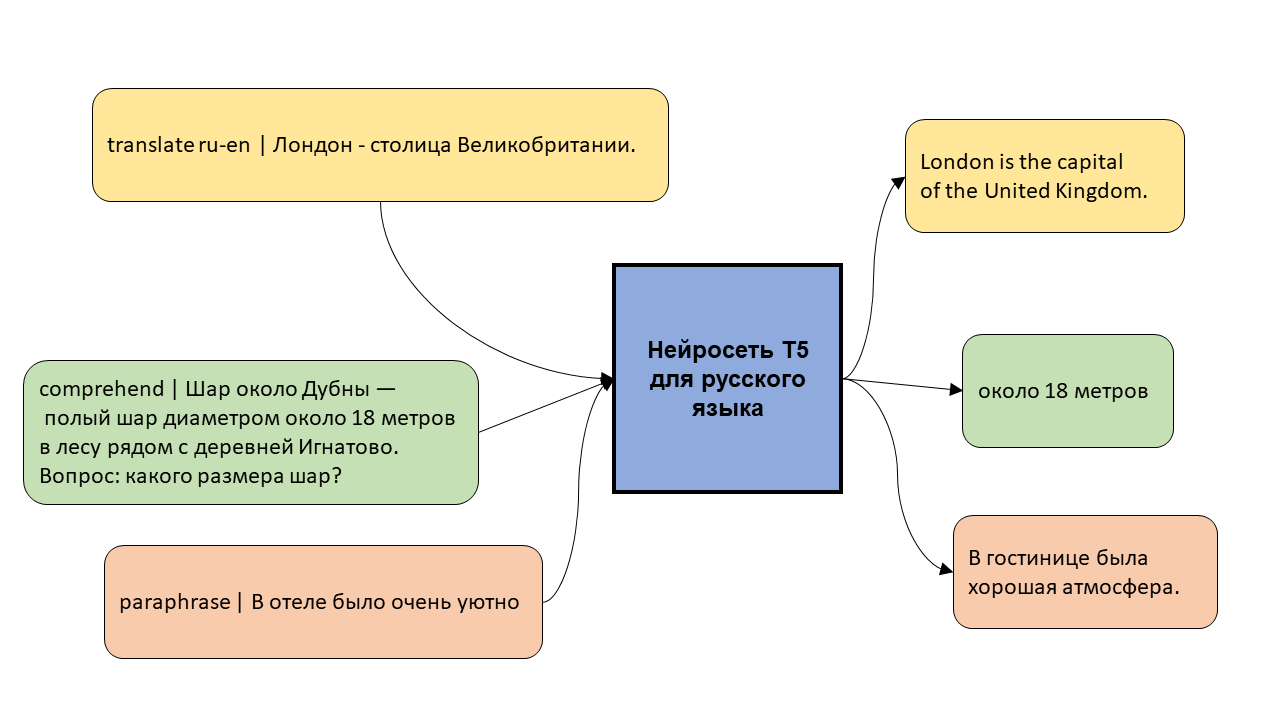


Проверка точности предсказания с помощью метрики ROUGE


In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("jd-salinger/rut5_base_sum_finetuned_habr")
model = AutoModelForSeq2SeqLM.from_pretrained("jd-salinger/rut5_base_sum_finetuned_habr")

config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/202 [00:00<?, ?B/s]

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import pandas as pd
import time

def generate_summary_batch_process(texts, model, tokenizer):
    model.to("cuda")

    # Generate summaries for the batch of texts
    input_ids = tokenizer.batch_encode_plus(texts, return_tensors="pt", max_length=1024, truncation=True, padding=True).to("cuda")
    summary_ids = model.generate(input_ids["input_ids"], max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decode and return the generated summaries
    generated_summaries = [tokenizer.decode(summary, skip_special_tokens=True) for summary in summary_ids]
    return generated_summaries

def process_batch(args):
    start, end, all_comments_summary = args

    tokenizer = AutoTokenizer.from_pretrained("jd-salinger/rut5_base_sum_finetuned_habr")
    model = AutoModelForSeq2SeqLM.from_pretrained("jd-salinger/rut5_base_sum_finetuned_habr")
    model.to("cuda")

    rows = all_comments_summary.iloc[start:end]
    texts_to_summarize = [' '.join(comment['text'] for comment in row['comments']) for _, row in rows.iterrows()]

    start_time = time.time()
    summaries = generate_summary_batch_process(texts_to_summarize, model, tokenizer)
    elapsed_time = time.time() - start_time

    # Print the time to calculate one summary_detox
    print(f"Time to calculate one summary_detox: {elapsed_time / len(texts_to_summarize):.5f} seconds")

    return summaries

def main():
    # Assuming you have loaded or created the DataFrame 'all_comments_summary' before this point

    # Split the DataFrame into batches for sequential processing
    batch_size = 10
    row_batches = [(i, i + batch_size, all_comments_summary) for i in range(0, len(all_comments_summary), batch_size)]

    # Sequentially process batches
    summaries_batches = [process_batch(batch) for batch in row_batches]

    # Flatten the list of batches into a single list of summaries
    all_summaries = [summary for batch in summaries_batches for summary in batch]

    # Assign the generated summaries to the DataFrame
    all_comments_summary['summary_detox'] = all_summaries

    # Now, 'summary_detox' column contains summaries for all rows
    # Access them using all_comments_summary['summary_detox']

if __name__ == "__main__":
    main()


Time to calculate one summary_detox: 1.41031 seconds


<ipython-input-9-281c6e13cfdf>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_comments_summary['summary_detox'] = all_summaries


In [10]:
all_comments_summary

,post_id,comments,post_text,comment_hashes,url,date,summary_detox
0,--SDWklGeAE,[{'text': ' @kryxmks. Зная большую часть люде...,"Приколы,BITTUEV,юмор,вайны,лучшие приколы,кари...",bb746cbc009b15cd6a0f451b102cb31e,http://www.youtube.com/watch?v=--SDWklGeAE,2023-11-21 11:50:09,В данном тексте автор выражает свое мнение о т...
1,-100194451_510298,"[{'text': '[id50188945|Сергей], это разве Угол...",Штрафы за дрифт начали приходить 🙈<hr/><br/><a...,7361155a282dda4629d018f07b4c24a9,http://vk.com/wall-100194451_510298,2023-11-23 20:31:01,"В тексте обсуждается разница между ""дрифтом"" и..."
2,-100272777_810169,[{'text': 'Да нет надо просто с лопатами к Адм...,Анонимно пожалуйста куда ещё звонить или писат...,e95970a83cee2788f8b968b4b6147236,http://vk.com/wall-100272777_810169,2023-11-23 09:10:13,В статье обсуждается ситуация с очисткой дорог...
3,-100283479_678834,"[{'text': 'Кошель та с рунами 🤔', 'url': 'http...","В магазине Пятерочка ул.Манченко, д.25 найден ...",4be8b6682fb38fbd172c0845fb78e1eb,http://vk.com/wall-100283479_678834,2023-11-24 10:42:28,"В тексте говорится о кошельке с рунами, которы..."
4,-100283479_679838,"[{'text': '[id22566180|Юрий], ""помню был удар,...","28.11.2023 , примерно в 20:30 вечера произошла...",0904907e4fcd6e311f0bb841e15843bb,http://vk.com/wall-100283479_679838,2023-11-29 07:12:13,"В тексте рассказывается о трех ударах, в котор..."
5,-100345006_751238,[{'text': 'Ты подарил мне в день рождения стир...,#начало или #продолжи_фразу\nТы подарил мне в ...,130ee0e3b90713eb23bdcdf17f589894,http://vk.com/wall-100345006_751238,2023-11-22 14:35:00,"В тексте рассказывается о том, как автор подар..."
6,-1003715_1457957,[{'text': 'Значит ли это что мы не скоро ...,Неизданные песни Майкла Джексона продают на ау...,927e493be792985883ee93e74147435c,http://vk.com/wall-1003715_1457957,2023-11-24 06:30:00,"В статье обсуждается вопрос о том, может ли но..."
7,-100426847_41979,"[{'text': 'Какой наполнитель? Цена?', 'url': '...",Красотки 🥰Любимки наши ❤️<br>А на Северной 76 ...,38ecc3d99768e2042b678afbd1dac877,http://vk.com/wall-100426847_41979,2023-11-25 16:15:42,В тексте говорится о цене на наполнитель для б...
8,-100548814_121765,"[{'text': '[id156309073|Александр], я не проти...",🔥 Корейцы есть? 😄 Если у вас есть знакомые / р...,0aaec9177e87a372d2f048012bf5d25c,http://vk.com/wall-100548814_121765,2023-11-27 23:20:00,"В тексте говорится о том, что многие из этих и..."
9,-10055384_7436142,"[{'text': '[id91837649|Віктор], 3 вроде даже, ...",Одна из лучших глав в Alan Wake II чуть не пош...,dfbb3da272473b9a41334bfdc0ab5d2c,http://vk.com/wall-10055384_7436142,2023-11-04 16:51:34,В статье обсуждаются различные аспекты геймпле...


In [ ]:
!pip install bert_score -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 875.4 kB/s eta 0:00:00


НОРМ КОД

In [ ]:
import pandas as pd
from bert_score import score
import numpy as np



all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)

references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

bert_score_df.head(7)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

,Precision,Recall,F1 Score
0,0.581221,0.540015,0.559861
1,0.378422,0.586400,0.459995
2,0.619869,0.608626,0.614196
3,0.453736,0.530297,0.489038
4,0.600296,0.674180,0.635097
5,0.671084,0.622410,0.645831
6,0.474954,0.634021,0.543080


FINE_TUNING

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 677.8 kB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install accelerate -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install accelerate>=0.20.1


In [ ]:
!pip install datasets -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score -qU

  Preparing metadata (setup.py) ... done


In [ ]:
import nltk
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_metric
import pandas as pd

# Assuming 'all_comments_summary' is your dataset
train_df, valid_df = train_test_split(all_comments_summary, test_size=0.2, random_state=42)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("jd-salinger/rut5_base_sum_finetuned_habr")
model = AutoModelForSeq2SeqLM.from_pretrained("jd-salinger/rut5_base_sum_finetuned_habr")

# Create pairs of comments and summaries for training dataset
comment_summary_pairs_train = [
    (comment['text'], summary)
    for _, row in train_df.iterrows()
    for comment, summary in zip(row['comments'], row['summary_detox'])
]

# Tokenize the training dataset
train_tokenized_datasets = tokenizer(
    [pair[0] for pair in comment_summary_pairs_train],
    [pair[1] for pair in comment_summary_pairs_train],
    padding=True,
    truncation=True,
    max_length=150,
    return_tensors="pt"
)

# Add labels to the training tokenized dataset
train_tokenized_datasets["labels"] = tokenizer(
    [pair[1] for pair in comment_summary_pairs_train],
    padding=True,
    truncation=True,
    max_length=150,
    return_tensors="pt"
)["input_ids"]

# Convert tokenized datasets to datasets.Dataset
train_dataset = Dataset.from_dict(train_tokenized_datasets)

# Load Rouge metric
rouge_metric = load_metric("rouge")

# Define the compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    # Compute Rouge scores
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)

    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5_finetuned",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    save_steps=1000,
    save_total_limit=2,
)

# Define Trainer with training dataset
trainer = Seq2SeqTrainer(
    model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()
trainer.push_to_hub()
all_comments_summary

<ipython-input-6-398fcb33c181>:45: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Exception ignored in: <function _xla_gc_callback at 0x7c6cc3095630>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback


Step,Training Loss


KeyboardInterrupt: ignored

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import pandas as pd
import time

def generate_summary_batch_process(texts, model, tokenizer):
    model.to("cuda")

    # Generate summaries for the batch of texts
    input_ids = tokenizer.batch_encode_plus(texts, return_tensors="pt", max_length=1024, truncation=True, padding=True).to("cuda")
    summary_ids = model.generate(input_ids["input_ids"], max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decode and return the generated summaries
    generated_summaries = [tokenizer.decode(summary, skip_special_tokens=True) for summary in summary_ids]
    return generated_summaries

def process_batch(args):
    start, end, all_comments_summary = args # Load model directly

    tokenizer = AutoTokenizer.from_pretrained("vicot2/t5_finetuned")
    model = AutoModelForSeq2SeqLM.from_pretrained("vicot2/t5_finetuned")
    model.to("cuda")

    rows = all_comments_summary.iloc[start:end]
    texts_to_summarize = [' '.join(comment['text'] for comment in row['comments']) for _, row in rows.iterrows()]

    start_time = time.time()
    summaries = generate_summary_batch_process(texts_to_summarize, model, tokenizer)
    elapsed_time = time.time() - start_time

    # Print the time to calculate one summary_detox
    print(f"Time to calculate one summary_detox: {elapsed_time / len(texts_to_summarize):.5f} seconds")

    return summaries

def main():
    # Assuming you have loaded or created the DataFrame 'all_comments_summary' before this point

    # Split the DataFrame into batches for sequential processing
    batch_size = 10
    row_batches = [(i, i + batch_size, all_comments_summary) for i in range(0, len(all_comments_summary), batch_size)]

    # Sequentially process batches
    summaries_batches = [process_batch(batch) for batch in row_batches]

    # Flatten the list of batches into a single list of summaries
    all_summaries = [summary for batch in summaries_batches for summary in batch]

    # Assign the generated summaries to the DataFrame
    all_comments_summary['summary_detox'] = all_summaries

    # Now, 'summary_detox' column contains summaries for all rows
    # Access them using all_comments_summary['summary_detox']

if __name__ == "__main__":
    main()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
